# **VisionGuard: Diabetic Retinopathy Detection System**

---



Diabetic retinopathy is a diabetes complication that affects the eyes. It is caused by damage to the blood vessels of the light-sensitive tissue at the back of the eye (retina). In its early stages, diabetic retinopathy may cause no symptoms or only mild vision problems, but it can eventually lead to blindness. High blood sugar levels over time can weaken and damage the small blood vessels within the retina, leading to leakage of blood or fluid. This can cause the retinal tissue to swell, resulting in cloudy or blurred vision.

There are two main stages of diabetic retinopathy: non-proliferative and proliferative. Non-proliferative diabetic retinopathy (NPDR) is the early stage where blood vessels in the retina are weakened. Proliferative diabetic retinopathy (PDR) is the advanced stage where new, abnormal blood vessels begin to grow in the retina. These new vessels can bleed into the vitreous, the gel-like substance that fills the center of the eye, causing severe vision loss or blindness. Early detection and treatment are crucial to prevent the progression of diabetic retinopathy. Regular eye exams and control of blood sugar, blood pressure, and cholesterol levels are essential to managing and reducing the risk of developing this condition.

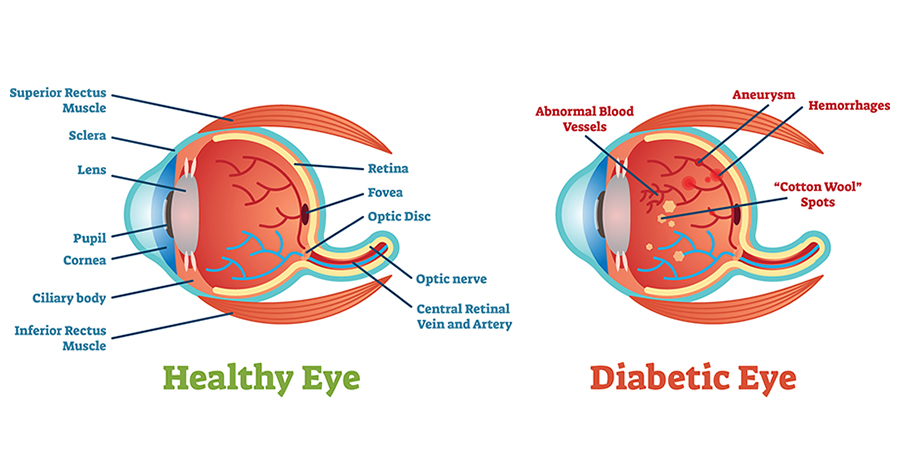

## **1. Loading Dataset**

In [6]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


This dataset consists of a large collection of high-resolution retinal images captured under various imaging conditions. A medical professional has assessed the presence of Diabetic Retinopathy in each image and assigned a rating on a scale ranging between 0 and 1, which corresponds to the following categories:


*   Diabetic Retinopathy ---> 0
*   No Diabetic Retinopathy ---> 1

## **2. Importing Essential Libraries**

---


'torchsummary' is a lightweight package that provides a summary of a PyTorch model, including the output shape and number of parameters at each layer. This can be helpful for understanding and debugging neural network architectures.

In [2]:
!pip install torchsummary


Imports a variety of essential libraries that will be used throughout the script for data manipulation, visualization, image processing, model building, training, and evaluation.

In [3]:
# Import essential libreries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

## **3. Data Preprocessing**

---



defines a set of image transformations that will be applied to the dataset. These transformations are crucial for preprocessing and augmenting the training data, which helps improve the robustness and generalization of the model.

In [4]:
# Define Transformation
transform = transforms.Compose(
    [
        transforms.Resize((255,255)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [8]:
!unzip archive.zip  # Replace with the actual filename of your ZIP

Archive:  archive.zip
  inflating: test/DR/00cb6555d108_png.rf.29cca170969c6e9918ef9b9209abef8e.jpg  
  inflating: test/DR/0104b032c141_png.rf.2b861f09f8526f5316cd44d8522bf62e.jpg  
  inflating: test/DR/03747397839f_png.rf.b634cf9fb09372b2c9c6bc6616bd5d7c.jpg  
  inflating: test/DR/04d029cfb612_png.rf.d9cf2e2a4e995a99b83e2595d66db6d2.jpg  
  inflating: test/DR/0ada12c0e78f_png.rf.3e8e491a2cacb9af201e2f89f3afca61.jpg  
  inflating: test/DR/0bf37ca3156a_png.rf.5fd49da65121f9fd951a208b5f085744.jpg  
  inflating: test/DR/0f495d87656a_png.rf.707a2bb8a1223a714fcb88d67eb153c0.jpg  
  inflating: test/DR/1177d583c807_png.rf.ecb8848ab217877e4877c8034c59b198.jpg  
  inflating: test/DR/1411c8ab7161_png.rf.892f5c081e1fb52861ed50975fc3a444.jpg  
  inflating: test/DR/144b01e7b993_png.rf.7307219cfcd0b42b5aec3c5f067bf949.jpg  
  inflating: test/DR/19244004583f_png.rf.e47d12272756f1cc269955068326ba95.jpg  
  inflating: test/DR/1c578b72d7b3_png.rf.c3dc207e90480de768e5dd5f5e69ce0e.jpg  
  inflating: test/

Defining the training, validation, and test datasets using the ImageFolder class from the torchvision.datasets module. The ImageFolder class is used to load datasets where the images are organized in a folder structure.

In [9]:
# Define object of the Train, Validation, and Test dataset.
train_set = torchvision.datasets.ImageFolder("train", transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder("valid", transform=transform)
val_set.transform
test_set = torchvision.datasets.ImageFolder("test", transform=transform)
test_set.transform

Compose(
    Resize(size=(255, 255), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

visualizing some images from the training set, which is crucial for understanding the data and ensuring that the transformations have been applied correctly.

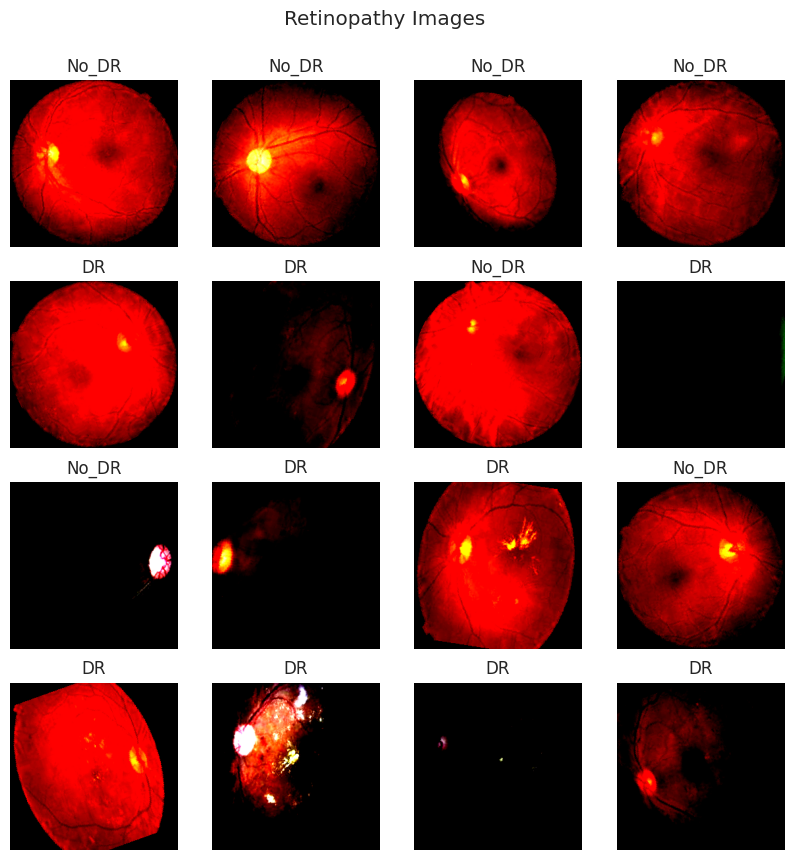

In [10]:
# Visualizing some images from Trainset
CLA_label = {
        0 : 'DR',
        1 : 'No_DR',
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Retinopathy Images', y=0.95)
plt.show()


## **4. Data Loading**

creating DataLoaders for the training, validation, and test datasets. DataLoaders handle the data loading process by creating mini-batches, optionally shuffling the data, and allowing for parallel data loading.

In [11]:
# Import and load Train, Validation and Test set
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

iterating through the train_loader and val_loader DataLoaders to print the shapes of the input data (X) and the corresponding labels (y).

In [12]:
# Print shape of Dataset
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 255, 255])
Shape of y: torch.Size([64]) torch.int64



## **5. Classification Module**

This function, 'findConv2dOutShape', is designed to calculate the output dimensions (height and width) of a convolutional layer in a neural network, given the input dimensions (hin for height and win for width), along with the parameters of the convolutional layer (conv).

In [13]:
'''This function can be useful in determining the output size of a convolutional layer,
given the input dimensions and the convolutional layer's parameters.'''

def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

The 'ImprovedCNN' class defines a convolutional neural network (CNN) architecture for a retinopathy detection model using PyTorch.


In [37]:
# ARCHITECTURE -1 =>
# # Define Architecture For Retinopathy Model
# class CNN_Retino(nn.Module):

#     def __init__(self, params):

#         super(CNN_Retino, self).__init__()

#         Cin,Hin,Win = params["shape_in"]
#         init_f = params["initial_filters"]
#         num_fc1 = params["num_fc1"]
#         num_classes = params["num_classes"]
#         self.dropout_rate = params["dropout_rate"]

#         # CNN Layers
#         self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
#         h,w=findConv2dOutShape(Hin,Win,self.conv1)
#         self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv2)
#         self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv3)
#         self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv4)

#         # compute the flatten size
#         self.num_flatten=h*w*8*init_f
#         self.fc1 = nn.Linear(self.num_flatten, num_fc1)
#         self.fc2 = nn.Linear(num_fc1, num_classes)

#     def forward(self,X):

#         X = F.relu(self.conv1(X));
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv2(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv3(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv4(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = X.view(-1, self.num_flatten)
#         X = F.relu(self.fc1(X))
#         X = F.dropout(X, self.dropout_rate)
#         X = self.fc2(X)
#         return F.log_softmax(X, dim=1)
#-------------------------------------------------------------------------------------------------

# NEW ARCHITECTURE =>
# Improved Architecture For Retinopathy Model
class ImprovedCNN(nn.Module):

    def __init__(self, params):
        super(ImprovedCNN, self).__init__()

        Cin, Hin, Win = params["shape_in"]
        init_f = params["initial_filters"]
        num_fc1 = params["num_fc1"]
        num_fc2 = params["num_fc2"]
        num_classes = params["num_classes"]
        self.dropout_rate = params["dropout_rate"]

        # CNN Layers with Batch Normalization
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(init_f)
        h, w = findConv2dOutShape(Hin, Win, self.conv1, pool=2) # Calculate output size after pooling

        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(2*init_f)
        h, w = findConv2dOutShape(h, w, self.conv2, pool=2) # Calculate output size after pooling

        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(4*init_f)
        h, w = findConv2dOutShape(h, w, self.conv3, pool=2) # Calculate output size after pooling

        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(8*init_f)
        h, w = findConv2dOutShape(h, w, self.conv4, pool=2) # Calculate output size after pooling

        # compute the flatten size
        self.num_flatten = h * w * 8 * init_f

        # Fully Connected Layers
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_fc2)
        self.fc3 = nn.Linear(num_fc2, num_classes)

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)

        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)

        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)

        X = F.relu(self.bn4(self.conv4(X)))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten) # Reshape the tensor
        X = F.relu(self.fc1(X))
        X = F.dropout(X, self.dropout_rate)

        X = F.relu(self.fc2(X))
        X = F.dropout(X, self.dropout_rate)

        X = self.fc3(X)
        return F.log_softmax(X, dim=1)


initializing an instance of the 'ImprovedCNN' class with specific parameters (params_model) and assigns it to a computation device

In [38]:
params_model={
        "shape_in": (3,255,255),
        "initial_filters": 8,
        "num_fc1": 100,
        "num_fc2": 50,
        "dropout_rate": 0.15,
        "num_classes": 2}

# Create instantiation of Network class
Retino_model = ImprovedCNN(params_model)

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Retino_model = Retino_model.to(device)

generating the model summary using the summary function for the 'ImprovedCNN' model

In [39]:
# Model Summary for ImprovedCNN
summary(Retino_model, input_size=(3, 255, 255))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 255, 255]             224
       BatchNorm2d-2          [-1, 8, 255, 255]              16
            Conv2d-3         [-1, 16, 127, 127]           1,168
       BatchNorm2d-4         [-1, 16, 127, 127]              32
            Conv2d-5           [-1, 32, 63, 63]           4,640
       BatchNorm2d-6           [-1, 32, 63, 63]              64
            Conv2d-7           [-1, 64, 31, 31]          18,496
       BatchNorm2d-8           [-1, 64, 31, 31]             128
            Linear-9                  [-1, 100]       1,440,100
           Linear-10                   [-1, 50]           5,050
           Linear-11                    [-1, 2]             102
Total params: 1,470,020
Trainable params: 1,470,020
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.74
Forw

## **6. Loss Function**

In [40]:
loss_func = nn.NLLLoss(reduction="sum")

## **7. Optimizer**

In [41]:
opt = optim.Adam(Retino_model.parameters(), lr=1e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

## **8. Training Model**

---



'get_lr' function retrieves the current learning rate from the optimizer. 'loss_batch' function computes the loss and the performance metric (accuracy) for a single batch of data. 'loss_epoch' function computes the average loss and performance metric (accuracy) over an entire dataset.

In [42]:
# Function to get the learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Function to compute the loss value per batch of data
def loss_batch(loss_func, output, target, opt=None):

    loss = loss_func(output, target) # get loss
    pred = output.argmax(dim=1, keepdim=True) # Get Output Class
    metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# Compute the loss value & performance metric for the entire dataset (epoch)
def loss_epoch(model,loss_func,dataset_dl,opt=None):

    run_loss=0.0
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop over dataset
    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        run_loss+=loss_b        # update running loss

        if metric_b is not None: # update running metric
            t_metric+=metric_b

    loss=run_loss/float(len_data)  # average loss value
    metric=t_metric/float(len_data) # average metric value

    return loss, metric

'train_val' function trains and evaluates a given neural network model over a specified number of epochs. It also tracks the learning rate, loss, and performance metrics, and saves the best model weights based on validation loss.

In [43]:
def train_val(model, params, verbose=False):

    # Get the parameters
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]

    # history of loss values in each epoch
    loss_history={"train": [],"val": []}
    # histroy of metric values in each epoch
    metric_history={"train": [],"val": []}
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    # initialize best loss to a large value
    best_loss=float('inf')

# Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.)

    for epoch in tqdm(range(epochs)):

        # Get the Learning Rate
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# Train Model Process


        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        # collect losses
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)


# Evaluate Model Process


        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

        # store best model
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [44]:
# Define various parameters used for training and evaluation of a cnn_model

params_train={
 "train": train_loader,"val": val_loader,
 "epochs": 60,
 "optimiser": optim.Adam(Retino_model.parameters(),lr=1e-4),
 "lr_change": ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

# train and validate the model
model,loss_hist_m,metric_hist_m = train_val(Retino_model,params_train)

  0%|          | 0/60 [00:00<?, ?it/s]

## **9. Evaluation**

---



plotting the convergence history of the training and validation loss as well as accuracy.

<Axes: >

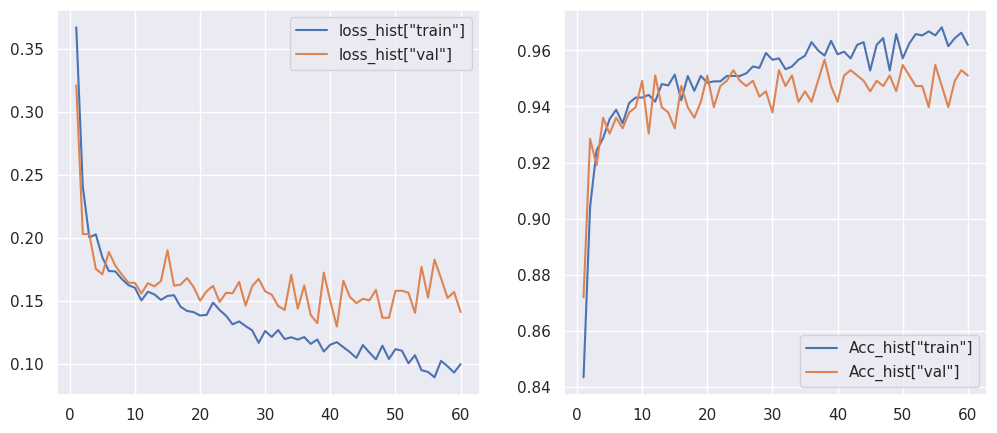

In [45]:
# Convergence History Plot
epochs=params_train["epochs"]
fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist_m["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["train"],ax=ax[1],label='Acc_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist_m["val"],ax=ax[1],label='Acc_hist["val"]')

function 'ture_and_pred_data' collects the true labels and predicted labels from the validation DataLoader. This is useful for generating a classification report.

In [46]:
# Define Function For Classification Report
def ture_and_pred_data(val_loader, model):
    i = 0
    y_true = []
    y_pred = []
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred

In [47]:
# Classification Report for Retinopathy Classification Model based on Train Set
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_true, y_pred = ture_and_pred_data(train_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', cm)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      1050
         1.0       0.96      0.97      0.96      1026

    accuracy                           0.96      2076
   macro avg       0.96      0.96      0.96      2076
weighted avg       0.96      0.96      0.96      2076
 


Accuracy: 0.9639

Confusion Matrix:
 [[1007   43]
 [  32  994]]


In [53]:
# # Classification Report for Retinopathy Classification Model based on Validation Set
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_true, y_pred = ture_and_pred_data(val_loader, Retino_model)
print(classification_report(y_true, y_pred), '\n\n')

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', cm)

              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       245
         1.0       0.95      0.97      0.96       286

    accuracy                           0.96       531
   macro avg       0.96      0.96      0.96       531
weighted avg       0.96      0.96      0.96       531
 


Accuracy: 0.9586

Confusion Matrix:
 [[231  14]
 [  8 278]]


In [54]:
torch.save(Retino_model, "Retino_model.pt")

In [55]:
# Load the pretrained model
model = torch.load("Retino_model.pt")

# Move the model to the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Iterate over the test loader for prediction
with torch.no_grad():
    for images, _ in test_loader:

        images = images.to(device)
        output = model(images)
        probabilities = torch.softmax(output, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        for predicted_class in predicted_classes:
            print("Predicted class:", predicted_class.item())

Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted class: 0
Predicted class: 1
Predicted class: 0
Predicted class: 1
Predicted class: 1
Predicted class: 0
Predicted cl

In [56]:
## Classification Report for Retinopathy Classification Model based on Test set
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix # Import the necessary functions

y_true, y_pred = ture_and_pred_data(test_loader, model)
print(classification_report(y_true, y_pred), '\n\n')

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}\n')

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', cm)

              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95       113
         1.0       0.93      0.97      0.95       118

    accuracy                           0.95       231
   macro avg       0.95      0.95      0.95       231
weighted avg       0.95      0.95      0.95       231
 


Accuracy: 0.9481

Confusion Matrix:
 [[104   9]
 [  3 115]]
